In [1]:
using Plots

In [2]:
report_filename = "atomic_mutex_benchmark.txt";

report = readlines(report_filename)

57-element Vector{String}:
 "Run on (16 X 2496 MHz CPU s)"
 "CPU Caches:"
 "  L1 Data 48 KiB (x8)"
 "  L1 Instruction 32 KiB (x8)"
 "  L2 Unified 512 KiB (x8)"
 "  L3 Unified 16384 KiB (x1)"
 "--------------------------------------------------------------------"
 "Benchmark                          Time             CPU   Iterations"
 "--------------------------------------------------------------------"
 "AtomicCounterBenchmark/1      600394 ns        59291 ns         8960"
 "AtomicCounterBenchmark/2     1159046 ns        87193 ns         8960"
 "AtomicCounterBenchmark/3     1433006 ns       129395 ns         6400"
 "AtomicCounterBenchmark/4     1606901 ns        89979 ns         7467"
 ⋮
 "MutexCounterBenchmark/13     5783043 ns       223214 ns         1120"
 "MutexCounterBenchmark/14     6437259 ns       218750 ns         1000"
 "MutexCounterBenchmark/15     7037927 ns       109375 ns         1000"
 "MutexCounterBenchmark/16     7447630 ns       187500 ns         1000"
 "MutexCounter

In [3]:
struct HardwareInfo
    concurency::Number
    frequency::Number
end

In [4]:
function ParseHardwareInfo()::HardwareInfo
    pattern::Regex = r"Run\son\s\((\d+)\sX\s(\d+)\sMHz\sCPU s\)"
    m = match(pattern, report[1])
    
    if m == nothing
        return HardwareInfo(0, 0)
    end
    
    return HardwareInfo(parse(Int64, m.captures[1]), parse(Int64, m.captures[2]))
end

ParseHardwareInfo (generic function with 1 method)

In [5]:
function FindMeasurementsIdx(lines::Vector{String})::Int32
    skips::UInt16 = 1
    for n = 1:length(lines)
           if startswith(lines[n], '-'^10)
            if skips == 0
            return n + 1
            else
            skips-=1;
            end
        end
    end
    return - 1
end;

In [6]:
struct Measure
    name::String
    range::Number
    time::Number
    cpu::Number
    iterations::Number
end

In [7]:
function ParseReportLine(line::String)::Measure
    pattern::Regex = r"^(\w+)\/?(\d*)\s*(\d+)\s\w{2}\s+(\d+)\s\w{2}\s+(\d+)$"
    m = match(pattern, line)
    
    if m == nothing
        throw(ErrorException("Invalid measure string"))
    end
    
    if length(m.captures[2]) == 0
        m.captures[2] = "0"
    end
    
    return Measure(
        m.captures[1], 
        parse(Int64, m.captures[2]),
        parse(Int64, m.captures[3]), 
        parse(Int64, m.captures[4]),
        parse(Int64, m.captures[5]))
end

ParseReportLine (generic function with 1 method)

In [8]:
struct PlotData
    title::String
    x::Vector{Int64}
    y::Vector{Int64}
end

In [9]:
function BuildPlotSeries()::Vector{PlotData}
    payloadIdx::Int64 = FindMeasurementsIdx(report)
    
    if payloadIdx == -1
        throw(ErrorException("Failed to find measurements"))
    end
    
    series::Dict{String, PlotData} = Dict()
    
    for n = payloadIdx:length(report)
        measure = ParseReportLine(report[n])
        s = get(series, measure.name, nothing)
        if s == nothing
            series[measure.name] = PlotData(measure.name, Vector(), Vector())
        else
            push!(s.x, measure.range)
            push!(s.y, measure.time)
        end
    end
    return collect(values(series))
end

BuildPlotSeries (generic function with 1 method)

In [10]:
function Plot(concurency::Bool)
    series = BuildPlotSeries()
    
    p = plot(
        map(s -> s.x, series), 
        map(s -> s.y, series),
        label=reshape(map(s -> s.title, series), (1, length(series))),
        legend=:topleft,
        fmt = :png)
    
    if concurency
        return vline!([ParseHardwareInfo().concurency], label="Hardware concurrency")
    else
        return p
    end
end

Plot (generic function with 1 method)

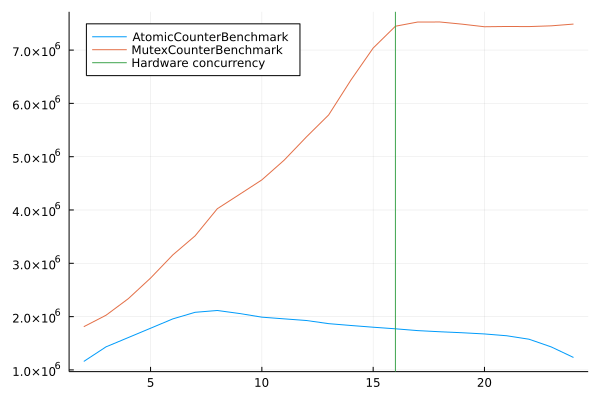

In [11]:
Plot(true)